#### An approximation of a sparse matrix (Oct 2019)

* The entries of a nonnegative matrix Y (nxm) are approximated by the use of Nonnegative Matrix Approximation (NMF):

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 
$$Y = P Q, P=\{p_{ik} \} \mbox{ is } n\times p \mbox{ and } Q=\{q_{kj} \} \mbox{ is } p\times m$$

* The number $p$ of the **latent components** is fixed but the approximation of the $Y$'s elements $y_{ij}$ is by the "integer combination":

$$ y_{ij} \approx s_{i1}q_{1j}+ \cdots + s_{ip}q_{pj}, \mbox{ } (*) $$

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 
where $0\ge s_{i1} \le s_{max}$ are integer and $s_{i1}+\cdots + s_{ip}=s_{max}$. Here $s_{max}$ is a fixed paramter similar to $p$.

* Approximation of this type can arise e.g. when a target set of ingredients ($y_{i\cdot}, i=1,\cdots,n$) needs to be delivered optimally through a combination of maximum $s_{max}$ predifined ingredient compounds (which are the latent components $1,...,p$). 


* The (sub)optimal solution $\hat{P}, \hat{Q}$ is achieved through an iterative alternating optimization of $P$ and $Q$ where at each step the integer coefficients $s_{i\cdot}$ in $(*)$ are found by a branch-and-bound approach to reduce number of computations (see method *search( )* below)

In [1]:
%load_ext autoreload
%autoreload 2

### Implementation of integer NMF for 1-row matrix

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from scipy.optimize import nnls
from queue import PriorityQueue 

### Generate all combinations with replacement
from itertools import combinations_with_replacement

### Q initialization
from sklearn.decomposition import NMF

np.set_printoptions(precision=3)
pd.set_option('precision', 4)      
%matplotlib inline

In [3]:
class CombinationOptimizer:
    def __init__(self, target, pill_ingr_matrix, max_pill):
        self.heuristic_cache = {}
        self.to_search = PriorityQueue()
        self.queue_copy = set()
        self.Q = pill_ingr_matrix
        self.y = target
        self.max_pill = max_pill
        self.n = pill_ingr_matrix.shape[0]  # the number of pills we have
        self.best_loss = np.inf              
        self.best_solution = (0,) * self.n
        self.to_search.put((self.heuristic(self.best_solution), self.best_solution))
        
    def branch(self, node):
        p = np.array(node)
        if p.sum() >= self.max_pill:
            return
        for i in range(self.n):
            child = p.copy()
            child[i] += 1
            yield tuple(child)
        
    def heuristic(self, node):
        if node in self.heuristic_cache:
            return self.heuristic_cache[node]
        p = np.array(node)[None,:]

        resid = (self.y - p.dot(self.Q))[0,]
        loss = np.linalg.norm(resid, 2)
        if loss < self.best_loss:
            self.best_loss = loss
            self.best_solution = node
        # NNLS     
        relaxed_solution, error = nnls(self.Q.T, resid)
        self.heuristic_cache[node] = error
        return error
    
    def search(self):
        while not self.to_search.empty():
            h, node = self.to_search.get()
            if h < self.best_loss:               
                for child in self.branch(node):
                    if child not in self.heuristic_cache: 
                        h = self.heuristic(child)
                        if h < self.best_loss:       
                                self.to_search.put((h, child))
        return self.best_solution
        
    def exact_solution(self):
        ### Get all of them
        ind = list(np.arange(1, self.n+1))
        P = [0]* self.n

        for t in np.arange(1, self.max_pill+1):
            comb = list(combinations_with_replacement(ind,t))
            comb_a = np.array(comb)
            for i in range(comb_a.shape[0]):
                ds = list(comb_a[i,:])
                arow = [ds.count(x) for x in set(ind)]
                P = np.vstack((P,arow))

        # remove the first row  
        P = P[1:, :]
        
        resid = np.repeat([self.y],P.shape[0],axis=0) - P.dot(self.Q)
        res_sq = np.apply_along_axis(np.linalg.norm, 1, resid)
        
        arg_min = np.argmin(res_sq)
        loss = res_sq[arg_min]
        sol = P[arg_min]
        
        return sol, loss       

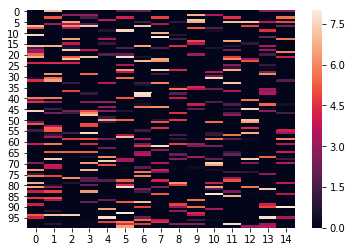

In [4]:
### Test with randomly generated data

n_targets = 100 # n_cust
n_ingr = 15 #
n_compnd = 8  # n_pill
max_compnd = 4  # max_pill

np.random.seed(2020)

Y = np.random.uniform(low=0, high=8, size=(n_targets, n_ingr))
# set most to zero
Y[np.random.binomial(n=1, p=.75, size=(n_targets, n_ingr)).astype(bool)] = 0
sns.heatmap(Y)

In [5]:
Y[:5,:]

array([[0.   , 6.987, 0.   , 0.   , 0.   , 1.736, 2.212, 0.   , 0.   ,
        0.   , 0.   , 0.   , 0.   , 2.845, 2.729],
       [0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   , 0.   , 0.   , 0.   , 0.   ],
       [0.   , 0.   , 2.987, 3.038, 0.   , 0.   , 0.   , 0.   , 0.   ,
        6.794, 3.539, 0.   , 0.   , 0.   , 0.   ],
       [0.   , 5.095, 0.   , 1.535, 0.   , 4.107, 0.   , 4.792, 0.   ,
        0.   , 0.   , 4.515, 0.   , 0.   , 5.578],
       [0.   , 0.   , 0.   , 0.   , 3.862, 0.   , 0.   , 0.   , 0.   ,
        7.188, 0.   , 0.   , 0.   , 0.133, 0.   ]])

In [6]:
# Initialize Q using NMF
model = NMF(n_components=n_compnd, init='random', random_state=0)
W = model.fit_transform(Y)
Qnmf = model.components_
Qnmf.round(2)

array([[1.34, 0.  , 0.  , 0.33, 0.  , 0.  , 0.  , 0.01, 0.14, 0.  , 0.07,
        0.  , 0.  , 0.01, 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.04, 1.85, 0.  , 0.  , 0.28, 0.  , 0.  ,
        0.41, 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.28, 0.  , 0.01, 2.61, 0.  , 0.  , 0.1 ,
        0.66, 0.  , 0.  , 0.  ],
       [0.  , 2.46, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.16, 0.  , 0.  ,
        0.  , 0.  , 0.01, 0.17],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 4.  , 0.  , 0.38, 0.  , 0.  ,
        0.  , 0.1 , 0.38, 0.36],
       [0.  , 0.  , 2.68, 2.2 , 0.  , 0.  , 0.  , 0.  , 0.  , 0.25, 0.  ,
        1.43, 0.07, 0.  , 1.16],
       [0.  , 0.  , 0.  , 0.  , 0.1 , 0.  , 0.  , 0.09, 0.03, 0.  , 1.72,
        0.  , 2.26, 0.  , 0.33],
       [0.  , 0.  , 0.05, 0.  , 2.25, 0.  , 0.  , 0.  , 0.57, 2.76, 0.  ,
        0.05, 0.  , 3.  , 0.58]])

In [7]:
# Run with 1st row of Y
cpo_nmf = CombinationOptimizer(Y[0,:], Qnmf, max_compnd)
solution = cpo_nmf.search()
print(f"Solution:\t{solution}")
print(f"Target:\t{Y[0,:]})")
print(f"Approximation:\t{np.array(solution).dot(Qnmf)}")
print(f"Loss:\t{cpo_nmf.best_loss}")

tree_size = 0
for i in range(1, max_compnd+1):
   tree_size += scipy.special.binom(n_compnd + max_compnd -1, max_compnd)
print(f"Explored {100*len(cpo_nmf.heuristic_cache)/tree_size:.0f}% of tree")

Solution:	(0, 0, 0, 3, 1, 0, 0, 0)
Target:	[0.    6.987 0.    0.    0.    1.736 2.212 0.    0.    0.    0.    0.
 0.    2.845 2.729])
Approximation:	[0.    7.394 0.    0.    0.    0.    3.999 0.    0.862 0.    0.    0.
 0.103 0.403 0.877]
Loss:	4.0642842838742235
Explored 13% of tree


In [8]:
e_sol = cpo_nmf.exact_solution()
e_sol

(array([0, 0, 0, 3, 1, 0, 0, 0]), 4.0642842838742235)

In [9]:
### Loop over all rows
loss_all=[0]
explored=[0]

for r in range(Y.shape[0]):
    cpo_nmf = CombinationOptimizer(Y[r,:], Qnmf, max_compnd)
    solution = cpo_nmf.search()
    tree_size = 0
    for i in range(1, max_compnd+1):
        tree_size += scipy.special.binom(n_compnd + max_compnd -1, max_compnd)
    loss_all= loss_all + [cpo_nmf.best_loss]
    explored= explored + [100*len(cpo_nmf.heuristic_cache)/tree_size]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a19319128>,
      dtype=object)

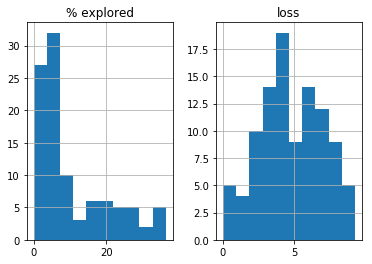

In [10]:
df100 = pd.DataFrame(data={'loss': loss_all, '% explored': explored})
df100.hist()

In [11]:
df100.describe()

,% explored,loss
count,101.0000,101.0000
mean,10.2400,4.7766
std,10.1064,2.2509
min,0.0000,0.0000
25%,2.5000,3.2600
50%,5.4545,4.6002
75%,15.8333,6.5722
max,36.4394,9.2888


----

### ALS (Alternating Least Square) for complete solution

In [12]:
def als(Y, n_compnd, max_compnd, n_iterations):
    tree_size = 0
    for i in range(1, max_compnd+1):
        tree_size += scipy.special.binom(n_compnd + max_compnd -1, max_compnd)

    # (1) Q initialization
    model = NMF(n_components=n_compnd, init='random', random_state=0)
    W = model.fit_transform(Y)
    Q0 = model.components_
    Q = Q0
    
    p, m = Q.shape  # p - num of compounds, m - num of ingredients

    # (2) ALS iterations
    loss = []
    explored = []
    delta_Q = []
    for k in range(n_iterations):
        
        # (2.1) Step P - (Loop over all rows - put this in a function)
        P_temp = []
        loss_iter=[0]
        explored_iter=[0]
        
        for r in range(Y.shape[0]):
            cpo_nmf = CombinationOptimizer(Y[r,:], Q, max_compnd)
            solution = cpo_nmf.search()
            loss_iter = loss_iter + [cpo_nmf.best_loss]
            explored_iter= explored_iter + [100*len(cpo_nmf.heuristic_cache)/tree_size] 
            P_temp.append(solution)
            
        # remove the first row / aggregate 
        P = np.array(P_temp)
        if k==0:
            P0 = P
        loss.append(np.mean(loss_iter))
        explored.append(np.mean(explored_iter))
        
        # (2.1) Step Q - construct Q column by column solving a NNLS
        Q_new = []
        for r in range(m): 
            Q_column, err = nnls(P, Y[:,r])
            Q_new.append(Q_column)
        # Remove the fake 1st row and transpose
        Q_new = np.array(Q_new).T 
        delta_Q.append(np.linalg.norm(Q-Q_new, 'fro'))
        Q = Q_new

    return P, Q, loss, explored, delta_Q, P0, Q0

In [13]:
# test
Pres = als(Y,10,6,60)

In [14]:
# P ====
Pres[0][:5,:]

array([[0, 1, 0, 3, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 1, 1, 0, 1],
       [0, 1, 0, 2, 0, 0, 0, 0, 2, 1],
       [0, 0, 0, 0, 0, 0, 0, 2, 0, 0]])

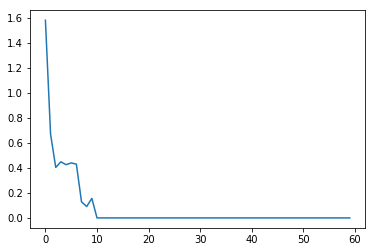

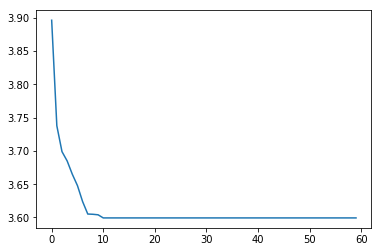

In [15]:
# Loss 
plt.plot(Pres[4])
plt.show()
# Change in Q
plt.plot(Pres[2])
plt.show()

In [16]:
# Q ====
np.set_printoptions(formatter={'float': lambda x: "{:6.2f}".format(x)})
Pres[1][:2,:]

array([[  2.48,   0.03,   0.25,   0.00,   0.00,   0.04,   0.00,   0.00,
          0.46,   0.00,   0.00,   0.00,   0.00,   0.07,   0.00],
       [  0.14,   0.11,   0.00,   0.02,   0.05,   2.77,   0.00,   0.01,
          0.37,   0.00,   0.13,   0.50,   0.00,   0.00,   0.00]])

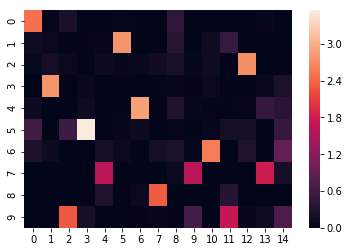

In [17]:
sns.heatmap(Pres[1])

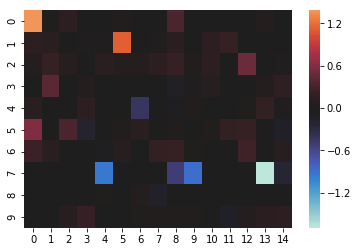

In [18]:
# Difference b/w last iteration Q and initial value Q
sns.heatmap(Pres[1]-Pres[6], center=0)